# TLC DataSet Analyze

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, unix_timestamp, avg, unix_timestamp, hour, to_timestamp, lag, when, mean, count, expr, date_format
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
from pyspark.sql.utils import AnalysisException
from geopy.distance import great_circle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Spark session 초기화
# Spark session 초기화
spark = SparkSession.builder \
    .appName("TLC DataSet Analyze") \
    .config("spark.driver.memory", "15g") \
    .config("spark.executor.memory", "15g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/02 12:48:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# SparkConf 가져오기
conf = spark.sparkContext.getConf()

# spark.driver.memory 설정 가져오기
driver_memory = conf.get("spark.driver.memory")

print(f"Spark Driver Memory: {driver_memory}")

Spark Driver Memory: 15g


### taxi zone data

In [4]:
# HDFS에서 CSV 파일 읽기
locations_df = spark.read.csv(
    "hdfs://hadoop-single:9000/opt/hadoop/taxi/taxi_zone.csv",  # hdfs
    header=True,
    inferSchema=True,
)
locations_df = locations_df.select(col("LocationID"), col("Latitude"), col("Longitude"))
locations_df = locations_df.withColumnRenamed("LocationID", "PULocationID")

# 위치 데이터를 딕셔너리로 변환하여 브로드캐스트
locations_dict = {
    row.PULocationID: (row.Latitude, row.Longitude) for row in locations_df.collect()
}
broadcast_locations = spark.sparkContext.broadcast(locations_dict)


In [5]:
# DataFrame 만들기 정의
def make_df(file_name, date):
    # parquet file 읽기
    file_path = f"hdfs://hadoop-single:9000/opt/hadoop/pi/{file_name}_tripdata_{date}.parquet"  # hdfs
    print(f"Attempting to read from: {file_path}")
    try:
        # 파일 읽기
        df = spark.read.parquet(file_path)
    except AnalysisException:
        print(f"File not found: {file_path}")
        return None  # 파일이 없으면 None 반환

    # 열 제거 및 이름 변경
    if file_name == "green":
        df = df.drop("ehail_fee")
    elif file_name == "fhv":
        df = df.drop("SR_Flag")

    # 결측치 있는 행 제거
    df = df.dropna()

    if file_name == "yellow":
        df = (
            df.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime")
            .withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")
            .filter(col("Airport_fee") >= 0)
        )
    elif file_name == "green":
        df = df.withColumnRenamed(
            "lpep_pickup_datetime", "pickup_datetime"
        ).withColumnRenamed("lpep_dropoff_datetime", "dropoff_datetime")
    elif file_name == "fhvhv":
        df = (
            df.withColumnRenamed("pickup_datetime", "pickup_datetime")
            .withColumnRenamed("dropoff_datetime", "dropoff_datetime")
            .withColumnRenamed("trip_miles", "trip_distance")
            .filter(col("sales_tax") >= 0)
            .filter(col("congestion_surcharge") >= 0)
            .filter(col("airport_fee") >= 0)
            .filter(col("tips") >= 0)
            .filter(col("driver_pay") >= 0)
        )
    elif file_name == "fhv":
        df = (
            df.withColumnRenamed("dropOff_datetime", "dropoff_datetime")
            .withColumnRenamed("PUlocationID", "PULocationID")
            .withColumnRenamed("DOlocationID", "DOLocationID")
        )

    if file_name in ["yellow", "green"]:
        df = (
            df.filter(col("passenger_count") >= 0)
            .filter(col("fare_amount") >= 0)
            .filter(col("extra") >= 0)
            .filter(col("mta_tax") >= 0)
            .filter(col("tip_amount") >= 0)
            .filter(col("tolls_amount") >= 0)
            .filter(col("improvement_surcharge") >= 0)
            .filter(col("total_amount") >= 0)
            .filter(col("congestion_surcharge") >= 0)
        )

    if file_name in ["green", "fhv"]:

        def calculate_distance(pu_lat, pu_lon, do_lat, do_lon):
            try:
                pu_lat, pu_lon, do_lat, do_lon = map(
                    float, [pu_lat, pu_lon, do_lat, do_lon]
                )
            except (ValueError, TypeError):
                return np.nan
            if pd.isna(pu_lat) or pd.isna(pu_lon) or pd.isna(do_lat) or pd.isna(do_lon):
                return np.nan
            pu_coords = (pu_lat, pu_lon)
            do_coords = (do_lat, do_lon)
            return (
                great_circle(pu_coords, do_coords).kilometers / 1.60934
            )  # 마일로 변환

        def get_distance(pu_id, do_id):
            locations = broadcast_locations.value
            pu_location = locations.get(pu_id)
            do_location = locations.get(do_id)
            if pu_location and do_location:
                pu_lat, pu_lon = pu_location
                do_lat, do_lon = do_location
                if (
                    pu_lat is not None
                    and pu_lon is not None
                    and do_lat is not None
                    and do_lon is not None
                ):
                    return calculate_distance(pu_lat, pu_lon, do_lat, do_lon)
            return None

        # UDF로 등록
        distance_udf = udf(get_distance, DoubleType())

        # 기존 DataFrame df에 새로운 컬럼 추가
        df = df.withColumn(
            "trip_distance", distance_udf("PULocationID", "DOLocationID")
        )

    # date를 이용해 해당 월의 첫 날과 마지막 날을 계산
    start_date = f"{date}-01"
    end_date = f"{date}-{(pd.Timestamp(start_date) + pd.offsets.MonthEnd(1)).day}"

    # pickup_datetime과 dropoff_datetime이 해당 월의 범위 내에 있는지 필터링
    df = df.filter(
        (col("pickup_datetime") >= start_date) &
        (col("pickup_datetime") <= end_date) &
        (col("dropoff_datetime") >= start_date) &
        (col("dropoff_datetime") <= end_date)
    )

    df = df.filter(col("trip_distance") > 0)
    df = df.dropna()

    df = df.filter(col("dropoff_datetime") > col("pickup_datetime"))

    # trip_duration과 trip_distance 계산 및 필터링
    df = df.withColumn(
        "trip_duration",
        (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60,
    )

    df = df.select("pickup_datetime", "trip_distance", "trip_duration")
    return df

### TLC data

In [6]:
# Data 타입, 범위
categories = ["yellow", "green", "fhv"]#, "fhvhv"]
months = (
    pd.date_range(start="2022-07-01", end="2022-07-01", freq="MS")
    .strftime("%Y-%m")
    .tolist()
)

# DataFrames 합치기
combined_df = None
for category in categories:
    for month in months:
        print(">>>>>", category, month)
        df = make_df(category, month)
        if df is not None:  # df가 None이 아닐 때만 결합
            if combined_df is None:
                combined_df = df
            else:
                combined_df = combined_df.union(df)
# combined_df.repartition(1).write.mode("append").csv(
#     "hdfs://hadoop-single:9000/opt/hadoop/pi/", header=True
# )  # hdfs

>>>>> yellow 2022-07
Attempting to read from: hdfs://hadoop-single:9000/opt/hadoop/pi/yellow_tripdata_2022-07.parquet


>>>>> green 2022-07
Attempting to read from: hdfs://hadoop-single:9000/opt/hadoop/pi/green_tripdata_2022-07.parquet
>>>>> fhv 2022-07
Attempting to read from: hdfs://hadoop-single:9000/opt/hadoop/pi/fhv_tripdata_2022-07.parquet


In [7]:
print("<<<<<<<<<<")
combined_df.show()
print(combined_df.count())

<<<<<<<<<<


+-------------------+-------------+------------------+
|    pickup_datetime|trip_distance|     trip_duration|
+-------------------+-------------+------------------+
|2022-07-01 00:20:06|         10.1|19.116666666666667|
|2022-07-01 00:29:11|         1.67| 8.816666666666666|
|2022-07-01 00:03:56|          0.9| 7.883333333333334|
|2022-07-01 00:18:36|         14.8| 34.13333333333333|
|2022-07-01 00:15:50|          1.2| 6.516666666666667|
|2022-07-01 00:31:06|          1.0|               4.1|
|2022-07-01 00:53:53|          3.0|14.283333333333333|
|2022-07-01 00:23:36|         1.37|              9.55|
|2022-07-01 00:38:53|         8.49|41.583333333333336|
|2022-07-01 00:26:21|         1.08| 4.516666666666667|
|2022-07-01 00:06:27|          8.3|              16.7|
|2022-07-01 00:39:23|          1.0|2.9166666666666665|
|2022-07-01 00:23:23|          1.6|10.016666666666667|
|2022-07-01 00:39:10|          2.2|              12.9|
|2022-07-01 00:52:45|          1.5| 6.483333333333333|
|2022-07-0


[Stage 8:=====================================>                    (9 + 5) / 14]



3223314


## 평균 택시 여행 시간과 거리 계산

In [8]:
# 평균 trip_distance와 trip_duration 계산
avg_values = combined_df.agg(
    avg("trip_distance").alias("average_trip_miles"),
    avg("trip_duration").alias("average_trip_duration"),
).collect()[0]

# 결과를 개별 변수로 추출
average_trip_miles = avg_values["average_trip_miles"]
average_trip_duration = avg_values["average_trip_duration"]

print(f"Average trip duration: {average_trip_duration:.2f} minutes")
print(f"Average trip distance: {average_trip_miles:.2f} miles")

Average trip duration: 17.82 minutes
Average trip distance: 3.69 miles


# 피크타임 분석

In [9]:
df = combined_df.withColumn('pickup_datetime', to_timestamp('pickup_datetime'))

# 각 시간대의 출발 여행 수 계산
df = df.withColumn('hour', hour(col('pickup_datetime')))
hourly_counts = df.groupBy('hour').count().orderBy('hour')

# 피크 시간 계산
peak_hour_row = hourly_counts.orderBy(col('count').desc()).first()
peak_hour = peak_hour_row['hour']
peak_hour_count = peak_hour_row['count']

# 시간대별 여행 수 데이터 수집 및 시각화
hourly_counts = hourly_counts.toPandas()  # hdfs

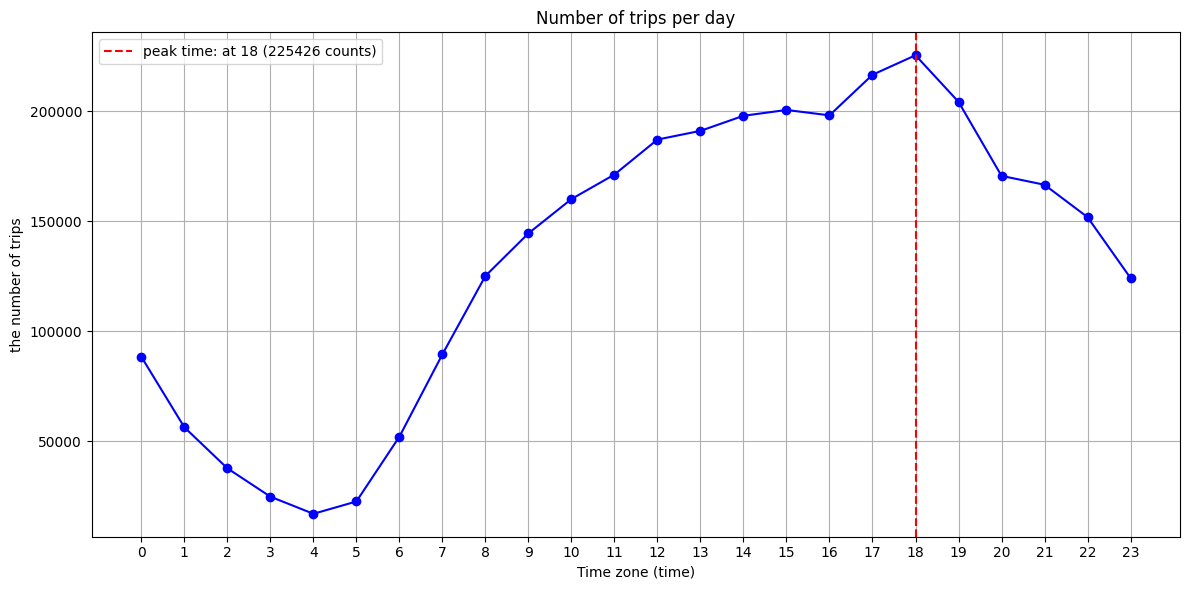

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_counts["hour"],
    hourly_counts["count"],
    marker="o",
    linestyle="-",
    color="blue",
)
plt.title("Number of trips per day")
plt.xlabel("Time zone (time)")
plt.ylabel("the number of trips")
plt.xticks(range(24))  # 0부터 23까지 시간대 표시
plt.grid(True)

# 피크 시간 강조
plt.axvline(
    x=peak_hour,
    color="red",
    linestyle="--",
    label=f"peak time: at {peak_hour} ({peak_hour_count} counts)",
)
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()

### weather data

In [11]:
weather_file_path = "hdfs://hadoop-single:9000/opt/hadoop/weather/weather.csv"
weather_df = spark.read.csv(
    weather_file_path,
    header=True,
    inferSchema=True,
)

In [12]:
combined_df = combined_df.withColumn(
    "pickup_datetime", date_format(col("pickup_datetime"), "yyyy-MM-dd HH:mm:ss")
)
combined_df = combined_df.repartition(10)
tlc_df = combined_df.toPandas()

In [13]:
weather_df = weather_df.withColumn("time", date_format(col("time"), "yyyy-MM-dd HH:mm:ss"))
weather_df = weather_df.toPandas()

# 강수량에 따른 평균 택시 여행 시간과 거리 계산

In [14]:
# 시간 형식 맞추기
weather_df["time"] = pd.to_datetime(weather_df["time"], format="%Y-%m-%d %H:%M:%S")
tlc_df["pickup_datetime"] = pd.to_datetime(tlc_df["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

# 시간에 맞게 정렬 (merge_asof 사용을 위해 필수)
weather_df = weather_df.sort_values("time")
tlc_df = tlc_df.sort_values("pickup_datetime")

# 가장 가까운 시간의 날씨 데이터 추가
tlc_df = pd.merge_asof(
    tlc_df,
    weather_df[["time", "temperature_2m (°C)", "rain (mm)"]],
    left_on="pickup_datetime",
    right_on="time",
    direction="backward",
)

# 불필요한 열 제거
tlc_df = tlc_df.drop(columns=["time"])
tlc_df

,pickup_datetime,trip_distance,trip_duration,temperature_2m (°C),rain (mm)
0,2022-07-01 00:00:01,7.100000,19.366667,27.2,0.0
1,2022-07-01 00:00:02,2.068183,16.700000,27.2,0.0
2,2022-07-01 00:00:03,0.500000,3.650000,27.2,0.0
3,2022-07-01 00:00:03,31.840000,51.716667,27.2,0.0
4,2022-07-01 00:00:03,17.550000,35.250000,27.2,0.0
...,...,...,...,...,...
3223309,2022-07-30 23:56:06,0.600000,3.166667,29.6,0.0
3223310,2022-07-30 23:56:15,0.590000,3.016667,29.6,0.0
3223311,2022-07-30 23:56:19,1.070000,3.683333,29.6,0.0
3223312,2022-07-30 23:56:28,0.800000,3.316667,29.6,0.0


In [15]:
# 비의 양에 따라 구분하기 위한 새로운 컬럼 생성
def rain_category(rain):
    if rain == 0:
        return "No Rain"
    elif rain <= 2:
        return "Light Rain"
    else:
        return "Heavy Rain"


tlc_df["rain_category"] = tlc_df["rain (mm)"].apply(rain_category)

# rain_category 컬럼을 기준으로 그룹화
rain_groups = tlc_df.groupby("rain_category")

# 각 그룹별로 요약 통계를 계산
rain_stats = rain_groups.agg(
    {
        "trip_distance": "mean",
        "trip_duration": ["mean", "count"],
        "temperature_2m (°C)": "mean",
    }
)

rain_stats

trip_distance trip_duration          temperature_2m (°C)
                       mean          mean    count                mean
rain_category                                                         
Heavy Rain         3.630964     16.163139    41098           29.783401
Light Rain         3.757407     17.474603   321405           26.955718
No Rain            3.682079     17.886458  2860811           26.976381

In [16]:
rdf = rain_stats.reset_index()
rdf.columns = ["rain_category", "trip_distance", "trip_duration", "count", "temperature"]
rdf


# 원하는 순서를 정의
order = ["No Rain", "Light Rain", "Heavy Rain"]

# 'temperature_category' 열을 Categorical 타입으로 변환하고, 순서를 정의
rdf['rain_category'] = pd.Categorical(rdf['rain_category'], categories=order, ordered=True)

# 데이터프레임을 지정된 순서로 정렬
rdf = rdf.sort_values('rain_category').reset_index(drop=True)

rdf

,rain_category,trip_distance,trip_duration,count,temperature
0,No Rain,3.682079,17.886458,2860811,26.976381
1,Light Rain,3.757407,17.474603,321405,26.955718
2,Heavy Rain,3.630964,16.163139,41098,29.783401


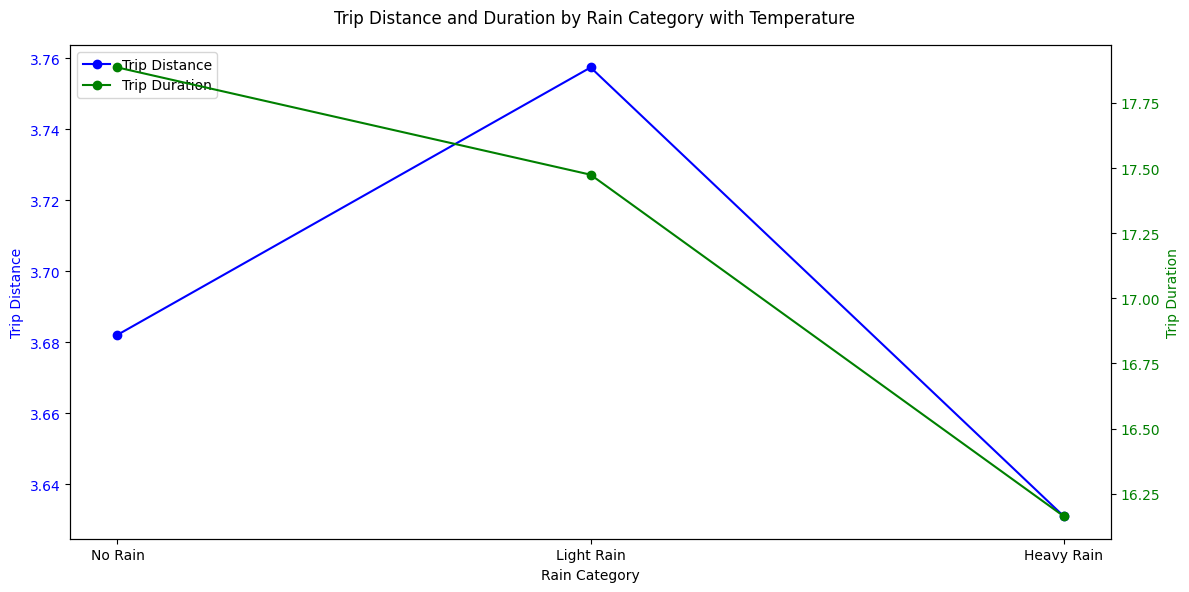

In [17]:
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 첫 번째 y축을 사용하여 trip_distance를 그립니다.
ax1.plot(rdf['rain_category'], rdf['trip_distance'], marker='o', color='b', label='Trip Distance')
ax1.set_xlabel('Rain Category')
ax1.set_ylabel('Trip Distance', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축을 사용하여 trip_duration을 그립니다.
ax2 = ax1.twinx()
ax2.plot(rdf['rain_category'], rdf['trip_duration'], marker='o', color='g', label='Trip Duration')
ax2.set_ylabel('Trip Duration', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# 타이틀과 레전드를 추가합니다.
fig.suptitle('Trip Distance and Duration by Rain Category with Temperature')
fig.tight_layout()

# 레전드와 범례
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.show()

# 기온에 따른 평균 택시 여행 시간과 거리 계산

In [18]:
weather_df['temperature_2m (°C)'].describe()

count    744.000000
mean      26.449194
std        3.093178
min       19.100000
25%       24.100000
50%       26.200000
75%       28.400000
max       34.600000
Name: temperature_2m (°C), dtype: float64

In [19]:
# 온도에 따라 구분하기 위한 새로운 컬럼 생성
def temperature_category(temp):
    if temp <= 24.1:
        return "Not Hot"
    elif temp <= 26.2:
        return "Slightly Hot"
    elif temp <= 28.4:
        return "fairly Hot"
    else:
        return "Very Hot"


tlc_df["temperature_category"] = tlc_df["temperature_2m (°C)"].apply(
    temperature_category
)

# temperature_category 컬럼을 기준으로 그룹화
temperature_groups = tlc_df.groupby("temperature_category")

# 각 그룹별로 요약 통계를 계산
temperature_stats = temperature_groups.agg(
    {
        "trip_distance": "mean",
        "trip_duration": ["mean", "count"],
        "rain (mm)": "mean",
    }
)

temperature_stats

trip_distance trip_duration          rain (mm)
                              mean          mean    count      mean
temperature_category                                               
Not Hot                   3.676232     18.088650   708982  0.044949
Slightly Hot              3.732005     18.186081   662233  0.028426
Very Hot                  3.608159     17.408184  1025450  0.107562
fairly Hot                3.765540     17.820503   826649  0.074988

In [20]:
tdf = temperature_stats.reset_index()
tdf

temperature_category trip_distance trip_duration          rain (mm)
                                mean          mean    count      mean
0              Not Hot      3.676232     18.088650   708982  0.044949
1         Slightly Hot      3.732005     18.186081   662233  0.028426
2             Very Hot      3.608159     17.408184  1025450  0.107562
3           fairly Hot      3.765540     17.820503   826649  0.074988

In [21]:
new_header = tdf.iloc[0]  # 첫 번째 행을 헤더로 저장
tdf.columns = ["temperature_category", "trip_distance", "trip_duration", "count", "rain"]

# 원하는 순서를 정의
order = ["Not Hot", "Slightly Hot", "fairly Hot", "Very Hot"]

# 'temperature_category' 열을 Categorical 타입으로 변환하고, 순서를 정의
tdf['temperature_category'] = pd.Categorical(tdf['temperature_category'], categories=order, ordered=True)

# 데이터프레임을 지정된 순서로 정렬
tdf = tdf.sort_values('temperature_category').reset_index(drop=True)

tdf


,temperature_category,trip_distance,trip_duration,count,rain
0,Not Hot,3.676232,18.088650,708982,0.044949
1,Slightly Hot,3.732005,18.186081,662233,0.028426
2,fairly Hot,3.765540,17.820503,826649,0.074988
3,Very Hot,3.608159,17.408184,1025450,0.107562


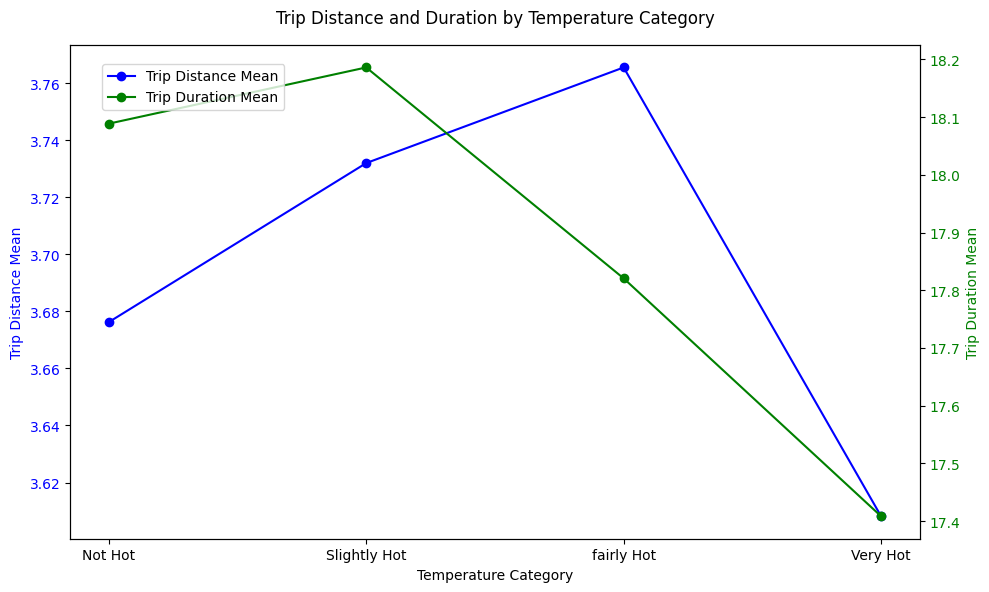

In [22]:
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축을 사용하여 trip_distance_mean을 그립니다.
ax1.plot(tdf['temperature_category'], tdf['trip_distance'], marker='o', color='b', label='Trip Distance Mean')
ax1.set_xlabel('Temperature Category')
ax1.set_ylabel('Trip Distance Mean', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축을 사용하여 trip_duration_mean을 그립니다.
ax2 = ax1.twinx()
ax2.plot(tdf['temperature_category'], tdf['trip_duration'], marker='o', color='g', label='Trip Duration Mean')
ax2.set_ylabel('Trip Duration Mean', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# 타이틀과 레전드를 추가합니다.
fig.suptitle('Trip Distance and Duration by Temperature Category')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.xticks(rotation=45)
plt.show()